In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import numpy as np


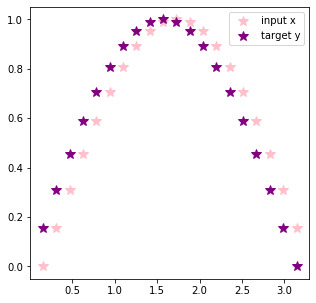

In [130]:
plt.figure(figsize=(5,5))

#how many timeseries /time step are in one batch of data
seq_length = 20

#generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
# add input size dimension
data.resize((seq_length + 1, 1))

x = data[:-1] #all but last
y = data[1:] #all but first

plt.plot(time_steps[1:], x, 'r*', color='pink', label='input x', markersize=10)
plt.plot(time_steps[1:], y, 'g*',color='purple', label='target y', markersize=10)
plt.legend(loc='best')
plt.show()

In [78]:
import torch.nn as nn
import torch.optim as optim

class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        #batch_first will add the batch size as first dimension (in most of the case, it is 'yes')
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
    def forward(self, x, hidden):
        # x size = batch_size, seq_length, input size
        # get the batch_size
        batch_size = x.size(0)
        
        #get rnn output
        output, hidden =self.rnn(x, hidden)
        
        #shape output to (batchsize * seqLength, hidden dimension)
        r_out = output.view(-1, self.hidden_dim)
        
        #get final output
        output = self.fc(r_out)
        return output, hidden

In [83]:
test_model = RNN(input_size=1,output_size=1,hidden_dim=10,n_layers=2)

time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))
test_input = torch.Tensor(data).unsqueeze(0) # give a batch dimension

print('Input size', test_input.size()) # [1, 20, 1] batchsize = 1, seq length = 20, input size = 1

test_output, test_hidden = test_model(test_input, None) 
print('Output size', test_output.size()) #[20, 1] batch size * seq lenght = 20,output size = 1
print('Hidden size', test_hidden.size()) #[2, 1, 10] n_layer = 2, batch size = 1, hidden dim = 10


Input size torch.Size([1, 20, 1])
Output size torch.Size([20, 1])
Hidden size torch.Size([2, 1, 10])


In [85]:
#decide hyperparameter
input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 3

#initiate rnn
rnn = RNN(input_size, output_size , hidden_dim, n_layers)
print(rnn)


RNN(
  (rnn): RNN(1, 32, num_layers=3, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [134]:

optimizer = optim.Adam(rnn.parameters(), lr=0.01)
criterion = nn.MSELoss()

def train (rnn, step, show_every):
    hidden = None
    for e in range(step):
        time_steps = np.linspace(e * np.pi, (e+1) * np.pi, seq_length+1)
        data = np.sin(time_steps) # shape (21,)
        data.resize((seq_length+1, 1)) # shape (21, ) Input size =1
        x = data[:-1]
        y = data[1:]
        x_tensor = torch.Tensor(x).unsqueeze(0) #  # shape (1, 20, 1) add a batch dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Represent Memory ##
        # make a new variable of hidden and detach the hidden state from its history
        # this way, we dont do backpropagation to the entire history
        hidden = hidden.data
        # calculate the loss
        loss = criterion(prediction, y_tensor)
        
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        if (e) % show_every == 0:
            print('Running loss', loss.item())
            plt.plot(time_steps[1:], x, 'r.', label = 'input')
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.', label ='prediction')
            plt.show()
        
    return rnn


Running loss 0.005418085027486086


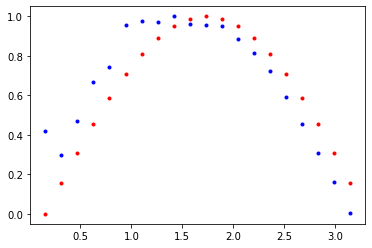

Running loss 0.013121115043759346


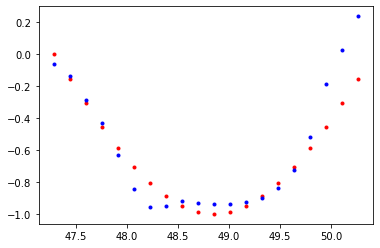

Running loss 0.002903626998886466


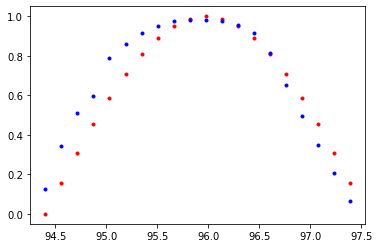

Running loss 0.0010612333426252007


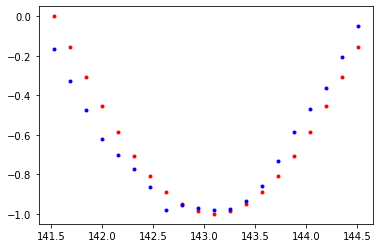

Running loss 0.000193799365661107


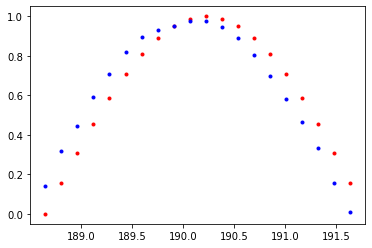

In [135]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)